In [144]:
import networkx as nx
import numpy
print(numpy.__version__)
import karateclub
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

1.21.5


In [162]:
with open("../data/synthetic_n500_Pred0.7_Phom0.025_Phet0.001.attr") as f:
    attr = [tuple(x.split(' ')) for x in f.read().strip().split('\n')]
    
with open("../data/synthetic_n500_Pred0.7_Phom0.025_Phet0.001.links") as f:
    
    links = [tuple(x.split(' ')) for x in f.read().strip().split('\n')]
    
len(attr), len(links)

(500, 3668)

In networkx, the nodes should start at 0, while in this dataset indexing starts at 1

In [163]:
# Re-index the nodes to start at 0
attr = [(str(int(node)-1), label) for (node, label) in attr]
links = [(str(int(i)-1), str(int(j)-1)) for (i, j) in links]

In [168]:
graph = nx.DiGraph(links)
for node, label in attr:
    if node not in graph.nodes:
        graph.add_node(int(node))
        
graph.number_of_nodes(), graph.number_of_edges()

(500, 3668)

In [169]:
model = karateclub.deepwalk.DeepWalk()
model.fit(graph)
model.get_embedding().shape

TypeError: '<' not supported between instances of 'int' and 'str'

The synthetic dataset consists of 500 nodes with label 0 or 1
It has only 3668 links which are all symmetric so a total of 1834 connections between nodes.

In [170]:
len(attr), len(links)/2

(500, 1834.0)

Our objective is to predict future links.
So our first step is to find all possible links that are not yet present

In [171]:
# capture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

# symmetric
links = links[::2]
for i in links:
  node_list_1.append(i[0])
  node_list_2.append(i[1])

# # a-symmetric
#   node_list_1.append(i[0])
#   node_list_2.append(i[1])
  
df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})
df

,node_1,node_2
0,0,103
1,0,113
2,0,116
3,0,127
4,0,211
...,...,...
1829,310,462
1830,321,482
1831,332,386
1832,344,413


We can represent these connections as a simple graph

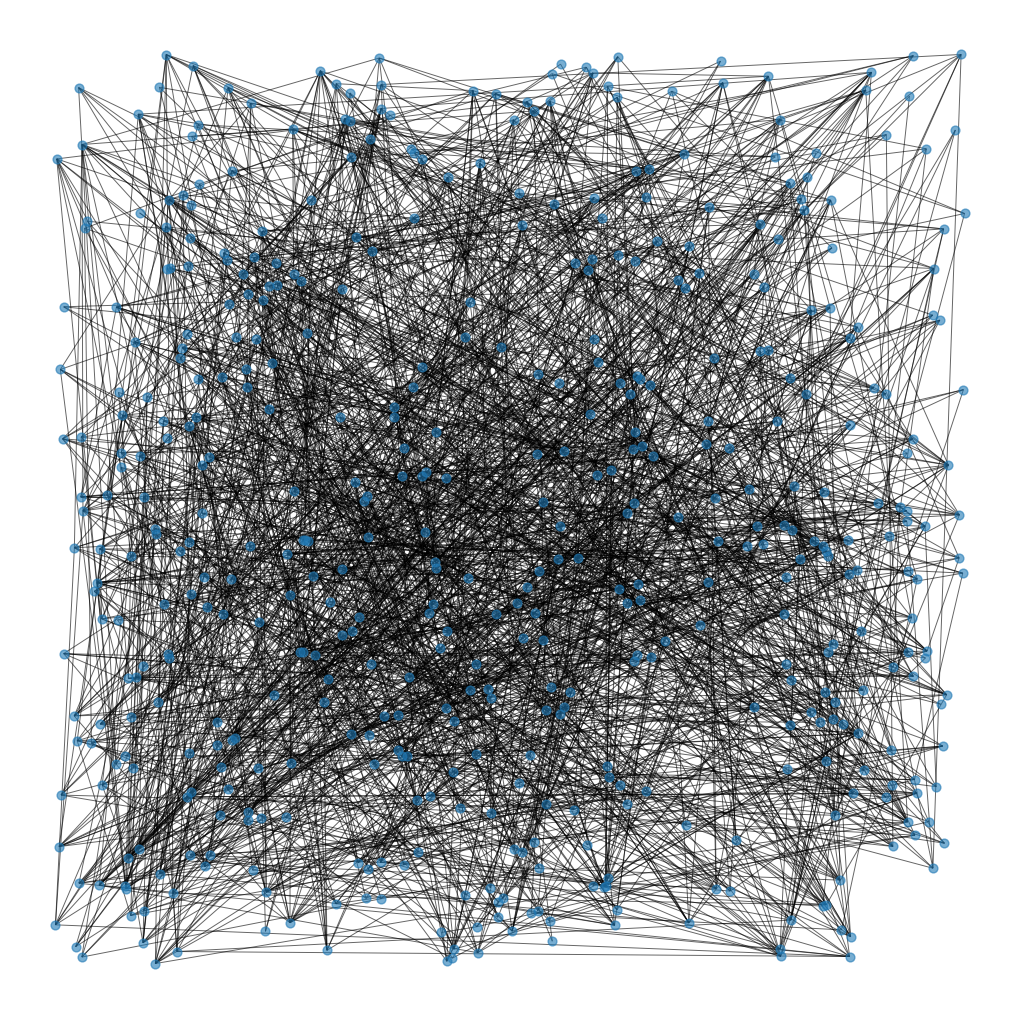

In [173]:
# create graph
G = nx.from_pandas_edgelist(df, "node_1", "node_2", create_using=nx.Graph())
# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

First, we will create an adjacency matrix to find which pairs of nodes are not connected.

In [174]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)
print(adj_G.shape)

(497, 497)


In [175]:
# assert shape
assert adj_G.shape == (len(attr), len(attr)), "Nodes that have 0 connections are missing"

AssertionError: Nodes that have 0 connections are missing

We see that the shape of our formed adjaceny matrix is not the same as squaring the number of nodes, this means that we have 3 isolated nodes that are not connected to any other node.
We will find out which nodes these are.

In [186]:
isolated_nodes = [node[0] for node in attr if node[0] not in node_list]
isolated_nodes

['159', '463', '486']

So the nodes 160 with label 1, 464 with label 0 and 487 with label 0 are not connected to any node. We will ignore these nodes, as we are using synthetic data, this won't affect our outcome. If we work with real data, we will have to find a solution for this.

Next task is to traverse trough the matrix to find the number of connections that can still be made

In [179]:
# build adjacency matrix with all nodes
# adj_G = nx.to_numpy_matrix(G, nodelist = attr)
# adj_G.shape

(500, 500)

In [187]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  if str(i) in isolated_nodes:
    continue
  for j in range(offset,adj_G.shape[1]):
    if str(j) in isolated_nodes:
      continue
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([attr[i],attr[j]])

  offset = offset + 1

# Note, some nodes are not connected at all

100%|██████████| 500/500 [00:05<00:00, 88.09it/s] 


In [188]:
len(all_unconnected_pairs)

14946

So we have 14946 possible future connections. These node pairs will act as negative samples during the training of the link prediction model. We will keep these pairs in a dataframe

In [195]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [196]:
data

,node_1,node_2,link
0,"(0, 1)","(1, 1)",0
1,"(0, 1)","(3, 1)",0
2,"(0, 1)","(5, 1)",0
3,"(0, 1)","(6, 1)",0
4,"(0, 1)","(10, 1)",0
...,...,...,...
14941,"(492, 0)","(490, 0)",0
14942,"(493, 0)","(498, 0)",0
14943,"(494, 0)","(499, 0)",0
14944,"(497, 0)","(498, 0)",0


Now that we have negative examples, we want to make some positive examples 

We will randomly drop some of the edges from the graph. However, randomly removing edges may result in cutting off loosely connected nodes and fragments of the graph. This is something that we have to take care of. We have to make sure that in the process of dropping edges, all the nodes of the graph should remain connected.

In the code block below, we will first check if dropping a node pair results in the splitting of the graph (number_connected_components > 1) or reduction in the number of nodes. If both things do not happen, then we drop that node pair and repeat the same process with the next node pair.

Eventually, we will get a list of node pairs that can be dropped from the graph and all the nodes would still remain intact:

In [ ]:
initial_node_count = len(G.nodes)

fb_df_temp = df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)